# Data Analysis

In this notebook we perform data analysis on the times at which summoners start playing games of League of Legends.



We first look at some time series date for a small number of players, then we will do data analysis on a large number of players.

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# I get this because of a copy warning using dataframes. More info is found here:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
# Ignoring all warnings is a horrible practice if you are running the code for the first time.
# However, upon further research I deemed the warning irrelevant, so I suppress it to make the output clean.
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Data Cleaning

We get data from Riot's API using the Riotwatcher package found here: https://github.com/pseudonym117/Riot-Watcher

However, the data is a little bit dirty and must be cleaned. I denote how the data is dirty and how I clean it below:

- The time stamp of the start of the game and the duration of the game that we get from Riot's API is in milliseconds instead of seconds, so we convert it to seconds, so we can then conver that into a datetime object using the datetime package.
<br>
<br>

- For some game modes (such as practice tool), the unix timestamp is listed as 0. A unix timestamp of 0 corresponds corresponds to the date that the unix timestamp timer started which is sometime in 1970, so this time given is incorrect. There isn't really a good way to treat this, so we will just delete these games from our data. This causes a problem where if a summoner played a practice tool game and then played some other game, then the $\Delta t$ that would get recorded corresponds to the time difference of the games after and before the practice tool game. For now we will ignore this, but some ways we can deal with this is either ommit players who play practice tool games, or when getting date using Riotwatcher, interpolate the timestamp according to the fetched games before and after the practice tool game. This is probably the best way to work with this data and I will improve this project that way in the future.
<br>
<br>

- Some of the time durations that we get from Riot's API seem to be in units of either ms or s, so we conver to s based on some criteria listed in the comments of the code below.

In [2]:
def clean_data(df):
    
    #A little after the time when Riot started adding timestamps to their data 
    #This is known as a Unix time stamp. 
    beginning = 1623987436 #June 18, 2021
    
    
    #Naming the columns
    df.columns = ["puuid", "match_id", "start_time", "duration"]

    
    #Drop duplicate values
    df.drop_duplicates(inplace=True)

    
    #Start time is measured in unix timestamp ms, so we convert to unix timestamp seconds
    df["start_time_seconds"] = df["start_time"]/1000

    
    #Creating column of datetimes for the start time of games
    df["start_time_date"] = df["start_time_seconds"].apply(lambda x : datetime.datetime.fromtimestamp(int(x)))
    
    
    #There are some games where the timestamps are messed up and start at 0, corresponding to 1970 (look up unix time)
    #So we remove these
    df = df[df["start_time_seconds"] > beginning]
    
    
    #duration is sometimes measured in seconds and sometimes in ms, so we conver to seconds via the condition:
    # If the duration of a game is in seconds, then when converting to minutes, if the duration is longer than 
    # 2 hours, we know this is far too long for a game, so the duration must actually be in ms, so we convert.
    df["duration_seconds"] = df["duration"].apply(lambda x : x/1000  if x/60 > 120 else x)

    
    #createa column for end_time since this is not tracked in all of the json files so we create it here
    df["end_time_seconds"] = df["start_time_seconds"] + df["duration_seconds"]

    
    #Sort the values by start_time
    df.sort_values(by = "start_time_seconds", ascending=True, inplace=True, ignore_index=True)

    
    #Creating a new column which measures the time difference between the start of a game and the end 
    # of the previous one
    del_t = []
    del_t.append(0)

    
    for i in range(1,len(df["start_time_seconds"])):

        del_t.append(df["start_time_seconds"][i] - df["end_time_seconds"][i-1])

        
    #In seconds
    df["del_t"] = del_t

    
    #Want the time between games in hours
    df["del_t_hours"] = df["del_t"]/(60*60)
    
    
    return(df)

# Time Between Games Played for one LoL Player

Let's do a little bit of analysis for $\Delta t$ for games played by a single LoL Player over a period of a few months.

Sometime last year I played a game of LoL. In that game there were 10 players total, including myself. This section portrays $\Delta t$ as a function of time for one of those players over a period of sevaral months.

In [3]:
df = pd.read_csv("Player_Time_Data_2/player_0_times.txt",
                      dtype='str,str,float,float', 
                      delimiter = " ",
                      usecols=(0,1,2,3),
                      header = None
                    )
    
df = clean_data(df)

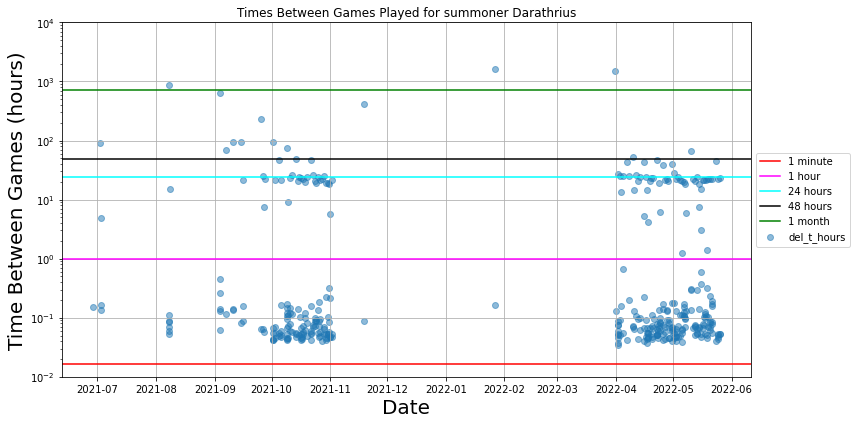

In [4]:
fig, ax = plt.subplots(figsize = (12,6))

ax.scatter(x = "start_time_date", y = "del_t_hours", data = df, alpha = .5)

#Creating horizontal lines represening delta t's of sevaral values
ax.axhline(y = 1/60,   c = "red",     label = "1 minute")
ax.axhline(y = 1,      c = "magenta", label = "1 hour")
ax.axhline(y = 24,     c = "cyan",    label = "24 hours")
ax.axhline(y = 48,     c = "black",   label = "48 hours")
ax.axhline(y = 24*30,  c = "green",   label = "1 month")


#Need a log scale because some data points are far larger than others, especially if a player 
# has almost churned
ax.set_yscale("log")

plt.xlabel("Date", fontsize = 20)
plt.ylabel("Time Between Games (hours)", fontsize = 20)


from riotwatcher import LolWatcher

watcher = LolWatcher(api_key="RGAPI-5d2f5d54-1012-42c4-b835-22ab1527dccb")
summoner_name = watcher.summoner.by_puuid('na1',df["puuid"][0])["name"]

plt.title("Times Between Games Played for summoner {}".format(summoner_name))


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.ylim(.01,10000)
plt.tight_layout()

In the plot above, on the x-axis is the start time of a game in terms of the date. On the y-axis is the time between the start of that game and the end of the previous game, $\Delta t$. This is the key metric we wish to analyze as it determines if a player almost churned: if $\Delta t$ is very large, it means it's the first time a summoner played a game in a long period of time. 
<br>
<br>

From the plot above, there are about 5 points where $\Delta t \approx 1 month$, meaning that it had been about a month since the last time the summoner played a game. Depending on what criteria you use, it can be argued that this summoner almost churned about 5 times.

# Time Between Games Played for 10 LoL Players

We now try to analyze $\Delta t$ vs $t$ of 10 LoL players and see if we can gain any insights from these plots.

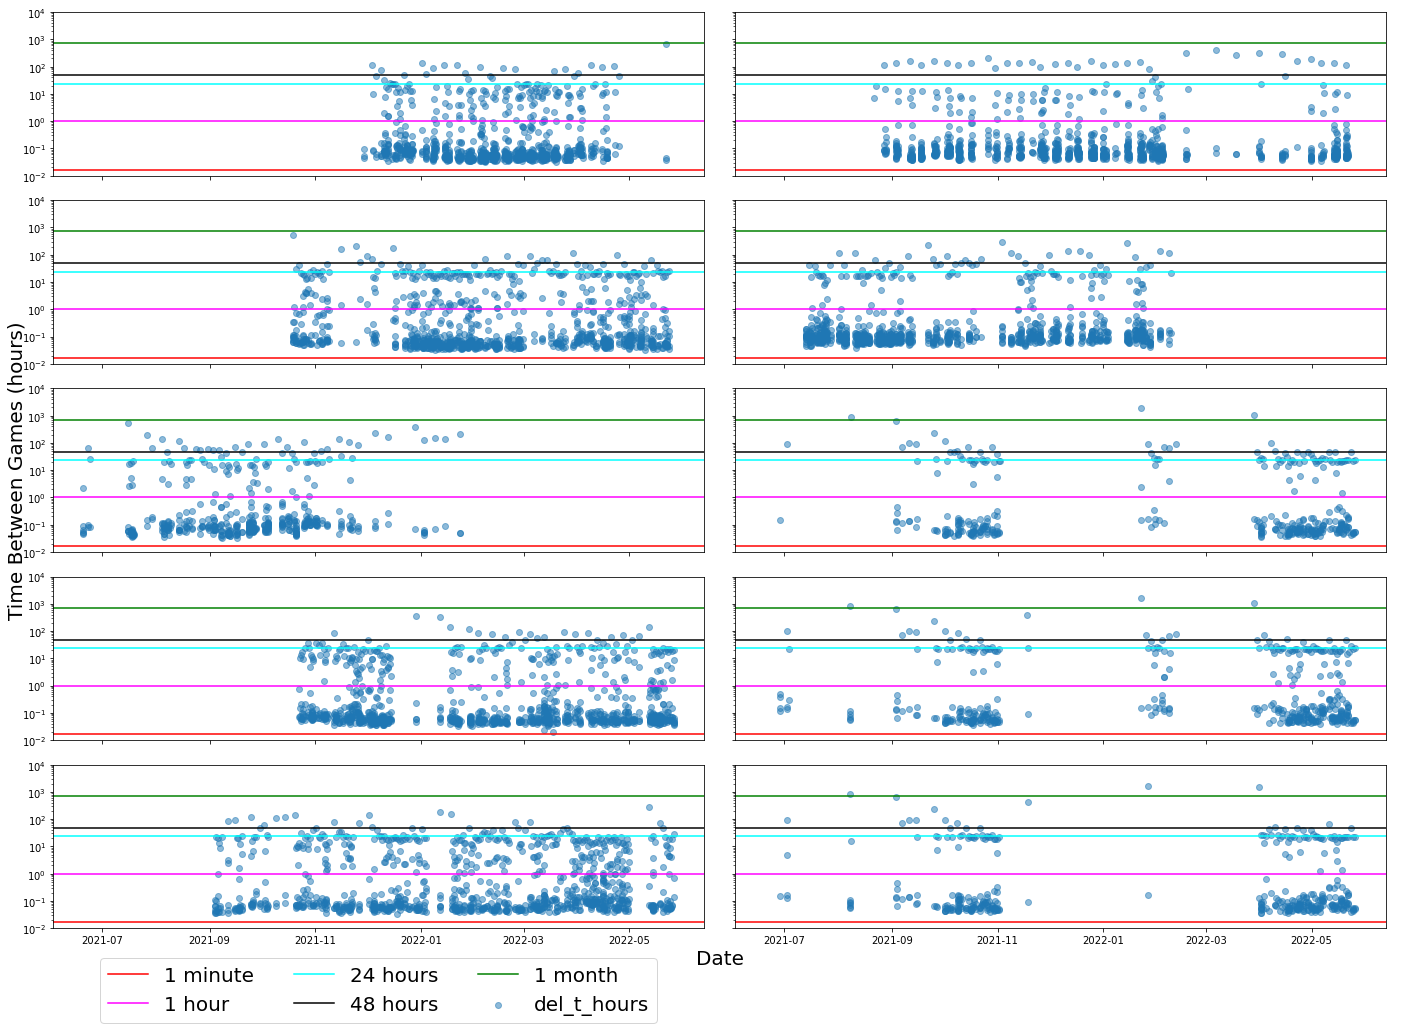

In [5]:
fig, axes = plt.subplots(nrows = 5, 
                       ncols=2, 
                       figsize = (20,15), 
                       sharex=True, 
                       sharey=True)


axis_list = [(0,0),(0,1),(1,0),(1,1),(2,0),(2,1),(3,0),(3,1),(4,0),(4,1)]

for i, filepath in enumerate(os.listdir("Player_Time_Data_2/")):
    
    df = pd.read_csv("Player_Time_Data_2/{}".format(filepath),
                      dtype='str,str,float,float', 
                      delimiter = " ",
                      usecols=(0,1,2,3),
                      header = None
                    )
    
    df = clean_data(df)
    
    axes[axis_list[i]].scatter(x = "start_time_date", y = "del_t_hours", data = df, alpha = .5)
    
    
    axes[axis_list[i]].axhline(y = 1/60,c = "red", label = "1 minute")
    axes[axis_list[i]].axhline(y = 1,   c = "magenta", label = "1 hour")
    axes[axis_list[i]].axhline(y = 24,  c = "cyan", label = "24 hours")
    axes[axis_list[i]].axhline(y = 48,  c = "black", label = "48 hours")
    axes[axis_list[i]].axhline(y = 24*30,  c = "green", label = "1 month")
    
    axes[axis_list[i]].set_yscale("log")
    
    #plt.xlabel("Date", fontsize = 20)
    #plt.ylabel("Hours Between Games", fontsize = 20)
    #plt.grid()
    plt.ylim(.01,10000)

    
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Date", fontsize = 20)
plt.ylabel("Time Between Games (hours)", fontsize = 20)
  
fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)  # create some space below the plots by increasing the bottom-value
axes.flatten()[-2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=3, prop={'size': 20})    


plt.tight_layout()

There are a few summoners who almost churned, represented by large gaps in points within a plot. In fact there are 3 summoners with very similar plots who all almost chured a few times. Upon checking op.gg, I find that these 3 players almost exlcusively queue up together. It makes sense that they almost churn at the same times as well. They all came back to LoL together it seems. Neat!

We also find from this analysis that two players actually churned, shown in plots (1,1) and (2,0). *I hope they do return to the rift*.

# Many Summoners' Data Analysis

Ok, so we explored a bit an individual summoner's game trends, and a group of 10 summoners' game trends. How do we explore data of many many summoners?

For N = 96 summoners, I acquired the start times and durations of every one of their games played from **INSERT BEGINNING DATE HERE** to **INSERT END DATE HERE**. There are two analyses that I do in the next sections of this notebook:

1. I create a histogram counting the number of games played per day by all the players. Since this is a time series we can do time series analysis to look for any noticeable patterns.
<br>
<br>
2. I get the time difference between the start of a game and the end of the previous game, denoted as $\Delta t$, for every single game in my dataset. Then, for each day I aggregate this game time separation by getting the mean of all the games within that day. This gives us the average time between games for all players in my dataset. I then plot this as a function of time and do time series analysis for any noticeable pattern, similar to the previous step. 
<br>
<br>

**But first, we must clean the data.**

## Cleaning

We have time data from N = 96 summoners which are contained in separate files, so we must join them together. We must also clean the data, I create a dataframe for each file of data, clean it, do this for all available summoner data sets, then join them into one new dataframe called df_new. However, in the code I wrote I clean each dataframe before I join them. This next batch of code explains my cleaning process in a very similar way to my earlier code by the same name.




In [6]:
def clean_data(df):
    
    add_4_days = 60*60*24*4
    
    
    #A little after the time when Riot started adding timestamps to their data 
    #This is known as a Unix time stamp. 
    beginning = 1623987436 #June 18, 2021
    
    
    #Naming the columns. For this data I also got data on if the summoner won their game or not, although
    # I do not use this in this project.
    df.columns = ["puuid", "match_id", "start_time", "duration", "win"]

    #Drop duplicate values
    df.drop_duplicates(inplace=True)

    #Changing from milliseconds to seconds
    df["start_time_seconds"] = df["start_time"]/1000

    #Creating column of datetimes for the start time of games
    df["start_time_date"] = df["start_time_seconds"].apply(lambda x : datetime.datetime.fromtimestamp(int(x)))

    
    #There are some games where the timestamps are messed up and start at 0, corresponding to 1970 (look up unix time)
    #So we remove these
    df = df[df["start_time_seconds"] > beginning]
    
    
    #df = df[df["start_time_seconds"] < now]
    
    #duration is sometimes measured in seconds and sometimes in ms, so we convert to seconds via the
    # same condition as given earlier.
    df["duration_seconds"] = df["duration"].apply(lambda x : x/1000  if x/60 > 120 else x)

    #create a column for end_time since this is not tracked in all of the json files
    df["end_time_seconds"] = df["start_time_seconds"] + df["duration_seconds"]

    #Sort the values by start_time
    df.sort_values(by = "start_time_seconds", ascending=True, inplace=True, ignore_index=True)

    #Creating a new column which measures the time difference between the start of a game and the end 
    # of the previous one
    del_t = []
    del_t.append(0)

    for i in range(1,len(df["start_time_seconds"])):

        del_t.append(df["start_time_seconds"][i] - df["end_time_seconds"][i-1])

    #In seconds
    df["del_t"] = del_t

    #Want the time between games in hours
    df["del_t_hours"] = df["del_t"]/(60*60)
    
    return(df)

In [7]:
#Getting all available files, combining them into one dataframe 

for i, file in enumerate(os.listdir("Player_Time_Data_Large_2/")):
    
    #Had some issues where notebook checkpoints were being read in so I include this line to ommit this file
    if file == ".ipynb_checkpoints": continue
    
    df = pd.read_csv("Player_Time_Data_Large_2/{}".format(file),
                      dtype='str,str,float,float,bool', 
                      delimiter = " ",
                      usecols=(0,1,2,3,4),
                      header = None
                    )

    df = clean_data(df)

    if i == 0:
        df_new = df
    
    else:
        df_new = pd.concat([df_new, df])

df_new.drop_duplicates(inplace = True)

We can split up the timeframe into different time slices, and group up games according to the time they began.  
For this project our slices are 1 day long.

In [8]:
df_new.head()

,puuid,match_id,start_time,duration,win,start_time_seconds,start_time_date,duration_seconds,end_time_seconds,del_t,del_t_hours
0,Y74k58z7N-Er6e0gaYeh_Fz3SI-uJ1mcM4lTTloYDawvkQ...,NA1_3950804244,1.624243e+12,935153.0,True,1.624243e+09,2021-06-20 19:37:33,935.153,1.624244e+09,0.000,0.000000
1,Y74k58z7N-Er6e0gaYeh_Fz3SI-uJ1mcM4lTTloYDawvkQ...,NA1_3950778095,1.624244e+12,1095642.0,True,1.624244e+09,2021-06-20 19:58:29,1095.642,1.624245e+09,320.720,0.089089
2,Y74k58z7N-Er6e0gaYeh_Fz3SI-uJ1mcM4lTTloYDawvkQ...,NA1_3950861846,1.624246e+12,1438652.0,False,1.624246e+09,2021-06-20 20:20:47,1438.652,1.624247e+09,241.797,0.067166
3,Y74k58z7N-Er6e0gaYeh_Fz3SI-uJ1mcM4lTTloYDawvkQ...,NA1_3950837023,1.624247e+12,1833039.0,False,1.624247e+09,2021-06-20 20:48:04,1833.039,1.624249e+09,198.562,0.055156
4,Y74k58z7N-Er6e0gaYeh_Fz3SI-uJ1mcM4lTTloYDawvkQ...,NA1_3951021748,1.624249e+12,766040.0,False,1.624249e+09,2021-06-20 21:23:09,766.040,1.624250e+09,272.139,0.075594


In [9]:
#We create a list of time stamps which we will use in the next cell.
date_stamps = pd.date_range('2021-06-17', '2022-05-28', freq='D')

In [10]:
#Creating function that will assign each datetime an index corresponding to the position
# of the date of the datetime within the time_stamps list. For example if the datetime is 2022-03-02 19:34:32 
#then this index will be the one corresponding to the position of 2022-03-02 in the time_stamps list.

def date_slice_assign(start_date):
    
    for i in range(len(date_stamps)):
        
        if (date_stamps[i] <= start_date) and (start_date < date_stamps[i+1]):
            
            return (date_stamps[i])
        
        
    
    
#    for i in range(len(time_stamps)):
#
#        if (time_stamps[i]  <= start_date) and (start_date < time_stamps[i+1]):
#
#            return (i)

In [11]:
#This code may take awhile depending on the time between dates you've chosen
#So both of these 2 snippets of code do the same thing, but the second one lets you keep track of which
# row you're on.

df_new["date_slice"] = df_new["start_time_date"].apply(date_slice_assign)

#date_list = []
#
#for i, date in enumerate(df_new["start_time_date"]):
#    
#    date_list.append(date_slice_assign(date))
#    print("added {}th date of {}, with date of {}".format(i, len(df_new["start_time_date"]),date_slice_assign(date)))
#    
#df_new["date_slice"] = date_list'''

# Games Played Per Day

Now that we have a dataframe with all games played by 95 different summoners we can aggregate by days in order to find the number of games played per day by the summoners in our dataset.

In [12]:
#We group by our new date_slice column and cout the number of games played per day by all 
# summoners in our dataset
grouped_df_date = df_new.groupby("date_slice").count()
grouped_df_date.head(3)

,puuid,match_id,start_time,duration,win,start_time_seconds,start_time_date,duration_seconds,end_time_seconds,del_t,del_t_hours
date_slice,,,,,,,,,,,
2021-06-17,77,77,77,77,77,77,77,77,77,77,77
2021-06-18,289,289,289,289,289,289,289,289,289,289,289
2021-06-19,273,273,273,273,273,273,273,273,273,273,273


I noticed that the first and last days are very low compared to the rest of the dataset. Then I realized that when I was taking the data I did not get the first or last day of my date at the start of those days, but at some arbitrary point in that day. This means that the entire day had not elapsed for these data points, thus I did not capture all of the games played for that day. So we will drop these data points.

In [13]:
#Dropping first and last data points corresponding to first and last date.
grouped_df_date.drop(index = [grouped_df_date.index.min(), grouped_df_date.index.max()], inplace = True)

In [14]:
#We turn the counts vs days into a time series object
counts_time_series = pd.Series(grouped_df_date["start_time_seconds"])

We would like to see if any noteable dates had any influence to the number of games played at or around that day. These dates include the start of season 12, when the Arcane skins dropped and when the Arcane show aired.

In [15]:
noteable_dates = ["2022-05-25", 
                  "2022-01-05", 
                  "2021-11-03", 
                  "2021-11-06", 
                  "2021-10-05",
                  "2021-11-06"]

noteable_dates_labels = ["Durability Update", 
                         "Start of Season 12", 
                         "Arcane Skins Dropped", 
                         "Arcane Show Aired",
                         "Worlds 2021 Starts",
                         "Worlds 2021 Final"]

color_list = ["r", "k", "green", "purple", "orange", "brown"]

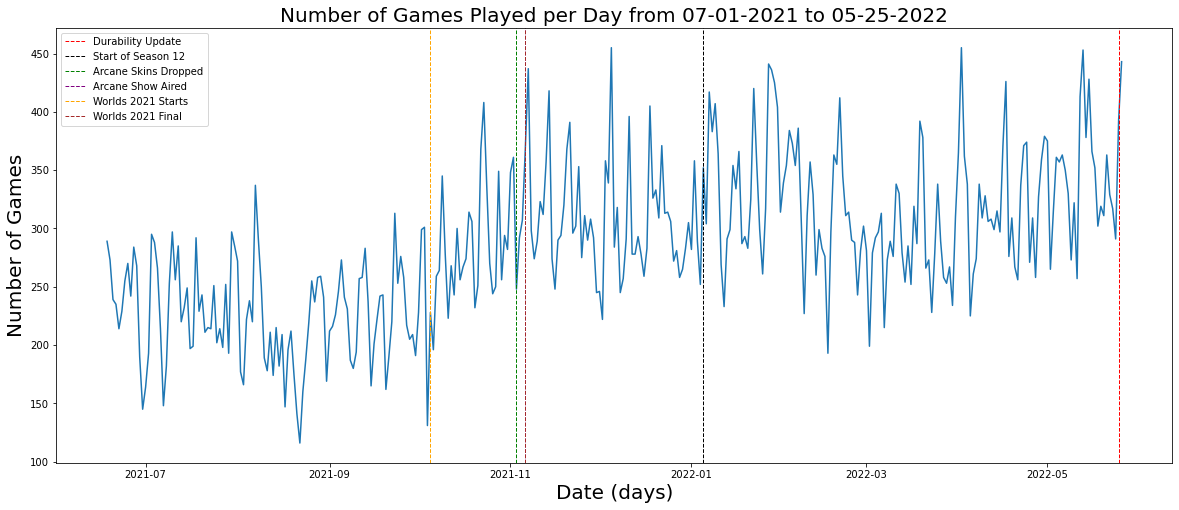

In [16]:
plt.figure(figsize = (20,8))

sns.lineplot(x = counts_time_series.index,
             y = counts_time_series,
             )

for i, date in enumerate(noteable_dates):
    
    plt.axvline(x = datetime.datetime.strptime(date, "%Y-%m-%d"), 
                label = noteable_dates_labels[i], 
                c = color_list[i],
                ls = "--",
                lw = 1
               )
    
plt.legend(loc = "best")
plt.xlabel("Date (days)", fontsize = 20)
plt.ylabel("Number of Games", fontsize = 20)
plt.title("Number of Games Played per Day from 07-01-2021 to 05-25-2022", fontsize = 20)

plt.show()

The data seems to be incredibly volatile and goes up and down, although not in any pattern I can see with my eyes except that it goes up a little then stagnates at around December 2021. We will have to do time series decomposition in order to separate the trend and seasonality from this data.
<br>
<br>
We do this by making the assumption that this time series is made up of 3 differente parts, the trend, the seasonality, and the error, which you can think of as follows:

- Trend: Tells you the general direction of where the time series is going. Since our dataset consists of veteran players, we expect that the tren will be stagnant and not increase or decrease unless affected by some outside influence.
<br>
<br>
- Seasonality: Tells you the cyclic pattern of the time series. Since our time series goes by days, we expect our cycles to be a week or a month long.
<br>
<br>
- Error: Tells you information on the time series that does not involve the trend or seasonality. In other words if the time series is only made up of these 3 parts, then the error tells you how factors outside of the general trend and seasonality affected your data at some point in time. 
<br>
<br>

**Let's decompose our time series into theses 3 components and analyze.**.

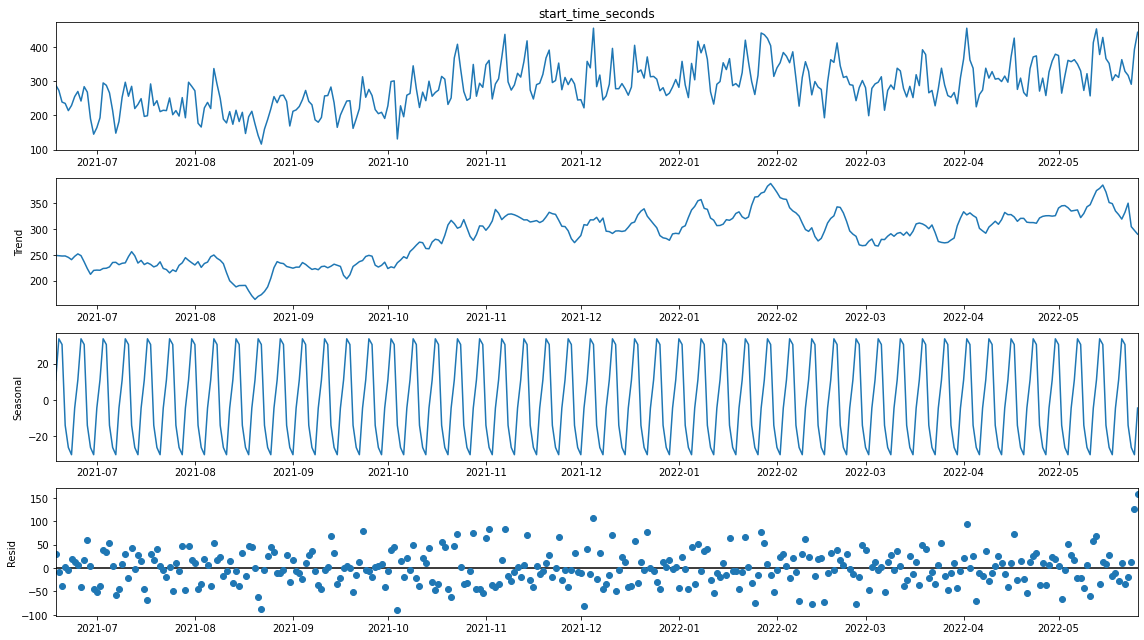

In [17]:
counts_decompose = seasonal_decompose(counts_time_series, extrapolate_trend="freq")

fig = counts_decompose.plot()

fig.set_size_inches((16, 9))
fig.tight_layout()

plt.show()

**Let's examine the game counts by each part of the time series:**

- Trend: Seems to be generally fluctuating, but around October 2011, seems to rise gradually. Then at about mid-February 2022 seems to fall a bit before rising again mid-March 2022.
<br>
<br>
- Seasonality: There appear to be 4 cycles between each month, corresponding to a weekly cycle (as we expected). This means that some days of the week, summoners play more and other parts summoners play less.
<br>
<br>
- Error: Hard to tell if there's a pattern because it's a scatterplot so **let's plot this on its own along with seasonality to see if it has any lingering effects on the residuals.**

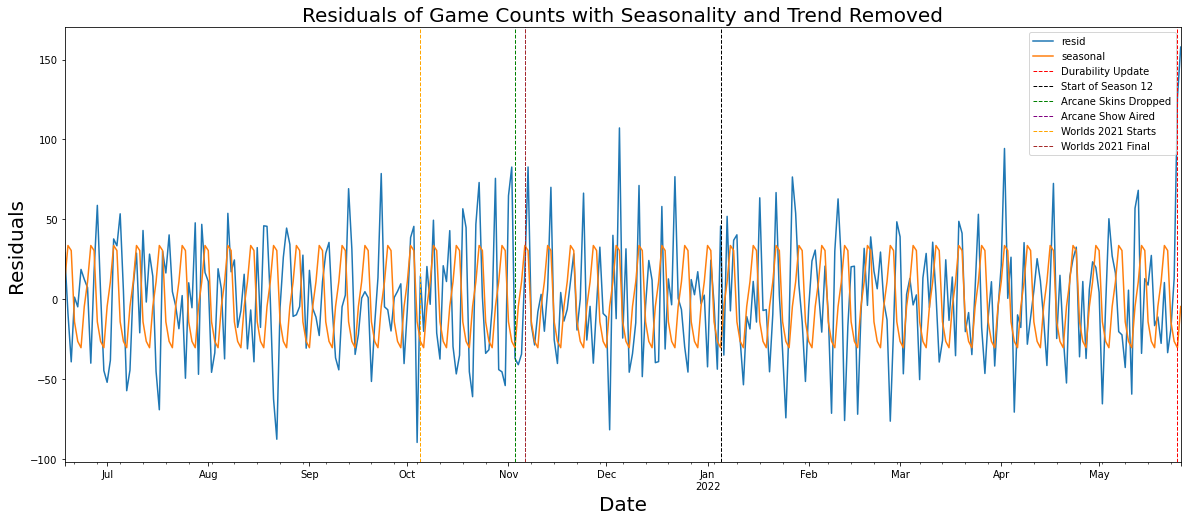

In [18]:
fig, ax = plt.subplots(figsize = (20,8))


counts_decompose.resid.plot(ax = ax)
counts_decompose.seasonal.plot(ax = ax)
plt.title("Residuals of Game Counts with Seasonality and Trend Removed", fontsize = 20)
plt.ylabel("Residuals", fontsize = 20)
plt.xlabel("Date", fontsize = 20)


for i, date in enumerate(noteable_dates):
    
    plt.axvline(x = date, 
                label = noteable_dates_labels[i], 
                c = color_list[i],
                ls = "--",
                lw = 1
               )
    
plt.legend(loc = "best")
plt.show()



The peaks and troughs of the seasonality part doesn't exactly line up with the peaks and troughs of the residuals.This makes me think that we have in fact removed the seasonality and these residuals are truly just random error. If this is the case then this is known as **white noise** Let's do a sanity chceck to see if we removed seasonality and trend. We conduct a **Dickey-Fuller test** for stationarity, if the p-value of this test less than .05 then the data is stationary, meaning there is no trend or seasonality anymore, which is what we expect and want by decomposing.

In [19]:
adft = adfuller(counts_decompose.resid,autolag="AIC")

output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

         Values                       Metric
0 -8.444974e+00              Test Statistics
1  1.722584e-13                      p-value
2  1.700000e+01             No. of lags used
3  3.250000e+02  Number of observations used
4 -3.450632e+00          critical value (1%)
5 -2.870474e+00          critical value (5%)
6 -2.571530e+00         critical value (10%)


We find that, according to the Dickey-Fuller test, our residual is indeed stationary. Let's take a closer look at just the residuals 

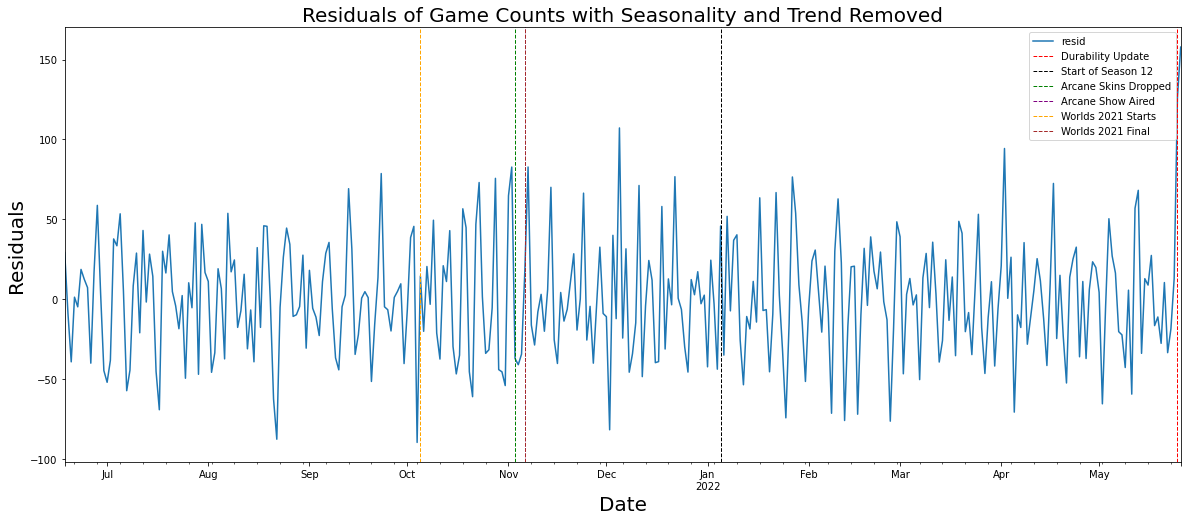

In [20]:
fig, ax = plt.subplots(figsize = (20,8))

counts_decompose.resid.plot(ax = ax)

plt.title("Residuals of Game Counts with Seasonality and Trend Removed", fontsize = 20)
plt.ylabel("Residuals", fontsize = 20)
plt.xlabel("Date", fontsize = 20)


for i, date in enumerate(noteable_dates):
    
    plt.axvline(x = date, 
                label = noteable_dates_labels[i], 
                c = color_list[i],
                ls = "--",
                lw = 1
               )
    
plt.legend(loc = "best")
plt.show()



There doesn't appear to be any clear influence from our events list. Maybe some of our events line up with some of the peaks or troughs, but realistically there are so many peaks and troughs that we are just grasping at straws.
<br>
<br>
The only pattern we see is in the trend, let's take a closer to look at what I mean.

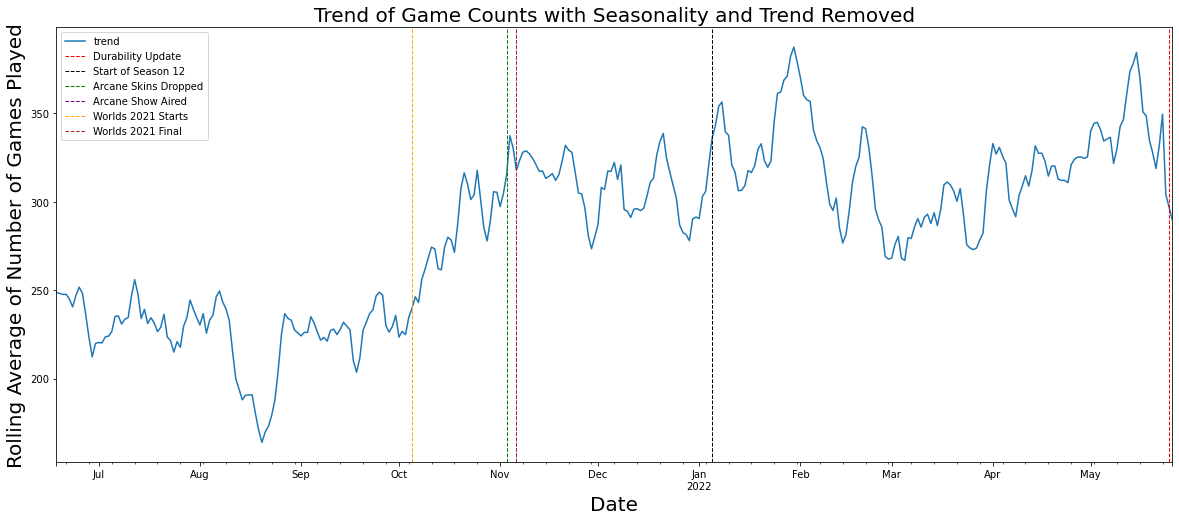

In [21]:
fig, ax = plt.subplots(figsize = (20,8))

counts_decompose.trend.plot(ax = ax)

plt.title("Trend of Game Counts with Seasonality and Trend Removed", fontsize = 20)
plt.ylabel("Rolling Average of Number of Games Played", fontsize = 20)
plt.xlabel("Date", fontsize = 20)


for i, date in enumerate(noteable_dates):
    
    plt.axvline(x = date, 
                label = noteable_dates_labels[i], 
                c = color_list[i],
                ls = "--",
                lw = 1
               )
    
plt.legend(loc = "best")
plt.show()

By looking at the trend, it seems as if the beginning of Worlds 2021 influenced summoners to play more overall over the next few months.

It doesn't seem as if the other events had any major influence on the trend.

We can conduct a **chanepoint analysis** to see if there is a statistically significant change in the trend of this time series. However, there is no straightforward-to-use library that implements this in Python and I will leave this as a future task for this project.

# $\Delta t$ Analysis

Now we wish to analyze the time series of $\Delta t$, which will give us some more information on the churn rate of players. 


Similarly to in our previous analsis we:

1. Assign each game to the date slice (such as 2022-01-05) to which the time the game was started at.
<br>
<br>
2. Now instead of aggregating in terms of the count of games that day (like we did previously), we **aggregate by the mean of $\Delta t$ for that day**.

In [22]:
#delete
#Grouping df by time slices 
grouped_del_t = df_new.groupby("date_slice").mean()

In [23]:
#Dropping first and last data points corresponding to first and last date just like before.
grouped_del_t.drop(index = [grouped_del_t.index.min(), grouped_del_t.index.max()], inplace = True)

In [24]:
grouped_del_t.head()

,start_time,duration,win,start_time_seconds,duration_seconds,end_time_seconds,del_t,del_t_hours
date_slice,,,,,,,,
2021-06-18,1.624060e+12,1.346673e+06,0.515571,1.624060e+09,1346.672855,1.624061e+09,5443.211519,1.512003
2021-06-19,1.624146e+12,1.349817e+06,0.523810,1.624146e+09,1349.816637,1.624147e+09,10306.358495,2.862877
2021-06-20,1.624234e+12,1.432597e+06,0.460251,1.624234e+09,1432.597331,1.624235e+09,18755.720255,5.209922
2021-06-21,1.624321e+12,1.394101e+06,0.536170,1.624321e+09,1394.101319,1.624322e+09,20990.973345,5.830826
2021-06-22,1.624403e+12,1.473939e+06,0.518692,1.624403e+09,1473.938645,1.624404e+09,21093.147584,5.859208


In [25]:
time_series = pd.Series(data = grouped_del_t["del_t_hours"])

# DOES THIS EVEN MAKE SENSE

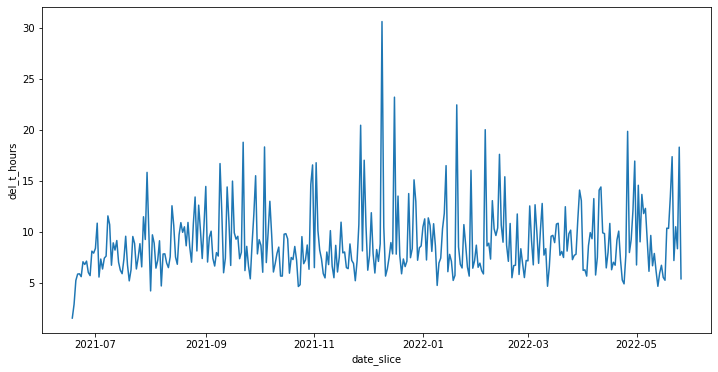

In [26]:
plt.figure(figsize = (12,6))
sns.lineplot(x = grouped_del_t.index,
            y = "del_t_hours",
            data = grouped_del_t)
plt.show()

Since we have a p-value less than .05, we reject the null hypothesis, and accept the alternative: this time series is stationary (no significant trend or seasonality).

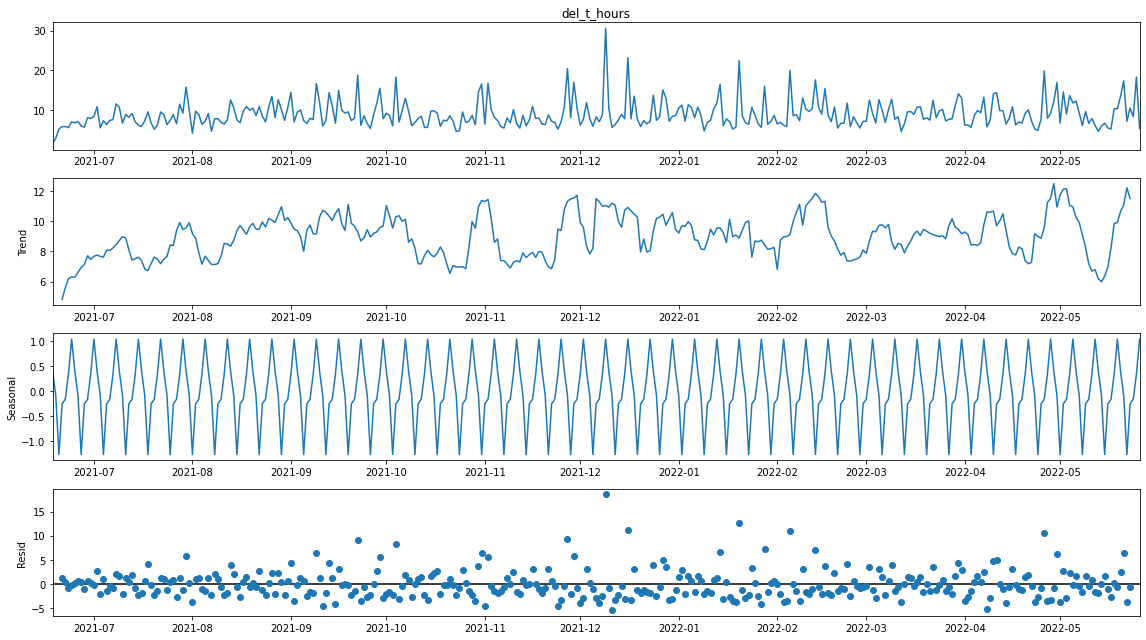

In [27]:
decompose = seasonal_decompose(time_series)


fig = decompose.plot()

fig.set_size_inches((16, 9))
fig.tight_layout()

plt.show()

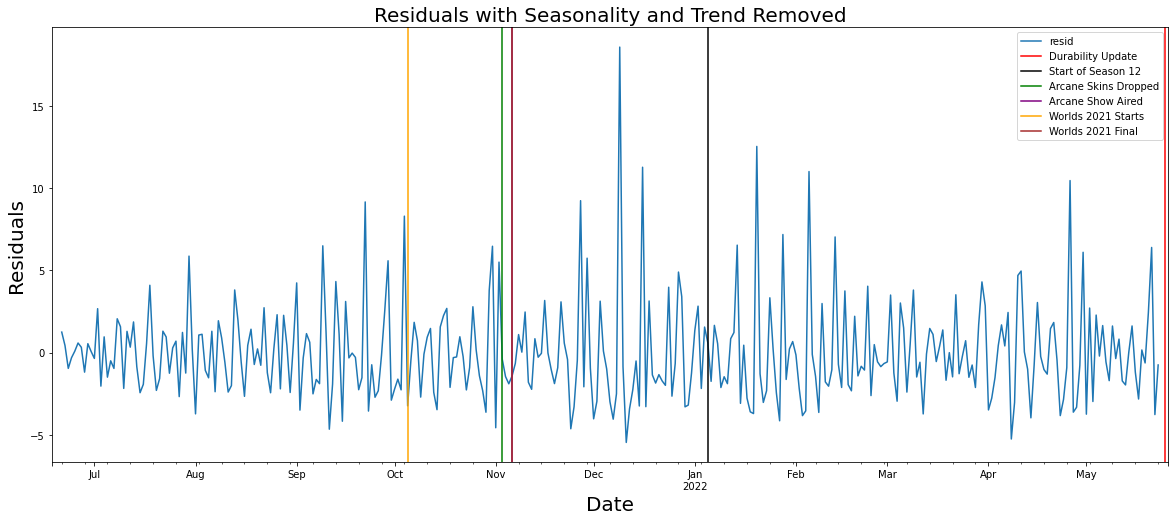

In [28]:
fig, ax = plt.subplots(figsize = (20,8))

decompose.resid.plot(ax = ax)

plt.title("Residuals with Seasonality and Trend Removed", fontsize = 20)
plt.ylabel("Residuals", fontsize = 20)
plt.xlabel("Date", fontsize = 20)


for i, date in enumerate(noteable_dates):
    
    plt.axvline(x = date, 
                label = noteable_dates_labels[i], 
                c = color_list[i]
               )
plt.legend(loc = "best")
plt.show()


# LOOK AT PLAYERS CHURNED AS F(T)

We defind as a player **almost churning** if they have not played a game in a month.

We define if a plyer **completely churned** if they have not played for over 2 months since the last time we have taken in data.

In [69]:
#List of summoner puuids of entire dataset
puuids = df_new["puuid"].unique()

#Date of the last game played for each summnoner, most will be the last day data was taken
last_game_dates = [] 


for puuid in puuids:
    
    last_game_date = df_new[df_new["puuid"] == puuid].sort_values(by = "start_time_date", ascending = False)["start_time_date"].iloc[0]
    
    last_game_dates.append(last_game_date)


In [70]:
#Getting the number of summoners who churned, almost churned, and are still playing LoL

summoners_churned = sum([date < date_stamps[-1] - datetime.timedelta(days = 61) for date in last_game_dates])

summoners_almost_churned = sum([(date_stamps[-1] - datetime.timedelta(days = 61) <= date) & (date < date_stamps[-1] - datetime.timedelta(days = 30)) for date in last_game_dates])

summoners_stayed = sum([date_stamps[-1] - datetime.timedelta(days = 30) <= date for date in last_game_dates])


summoners_sum = summoners_churned + summoners_almost_churned + summoners_stayed

summoners_churned_per = summoners_churned/summoners_sum * 100
summoners_almost_churned_per = summoners_almost_churned/summoners_sum * 100
summoners_stayed_per = summoners_stayed/summoners_sum * 100

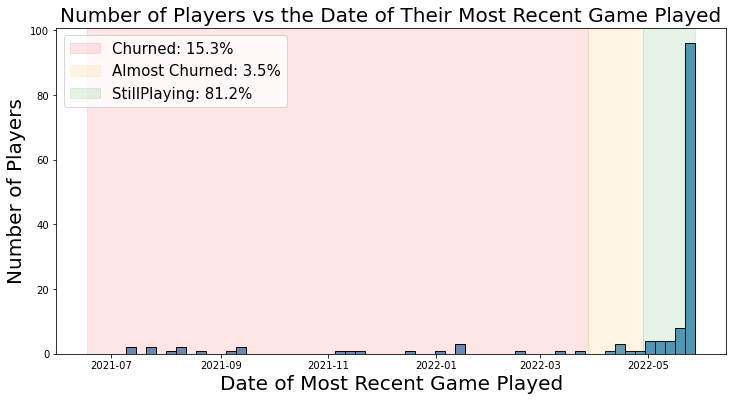

In [71]:
plt.figure(figsize = (12,6))

sns.histplot(last_game_dates)






plt.axvspan(date_stamps[0], date_stamps[-1] - datetime.timedelta(days = 61), color='red', alpha=0.1, label = "Churned: {:.1f}%".format(summoners_churned_per))

plt.axvspan(date_stamps[-1] - datetime.timedelta(days = 61), date_stamps[-1] - datetime.timedelta(days = 30), color='orange', alpha=0.1, label = "Almost Churned: {:.1f}%".format(summoners_almost_churned_per))

plt.axvspan(date_stamps[-1] - datetime.timedelta(days = 30), date_stamps[-1], color='green', alpha=0.1, label = "StillPlaying: {:.1f}%".format(summoners_stayed_per))


plt.ylabel("Number of Players", fontsize = 20)
plt.xlabel("Date of Most Recent Game Played", fontsize = 20)
plt.title("Number of Players vs the Date of Their Most Recent Game Played", fontsize = 20)
plt.legend(fontsize = 15)

In [72]:
print("Since July 18, there have been {} summoners who have churned and {} who have almost churned out of {} total summoners whose data we acquired".format(summoners_churned,summoners_almost_churned, len(puuids)))

Since July 18, there have been 22 summoners who have churned and 5 who have almost churned out of 144 total summoners whose data we acquired


# Analyzing Sessions and Session Separations 

previous point is 1 minute <= time < 2 hours 

Game belongs in **session** if it meets one of these two conditions



1 minute <= time < 2 hours

OR




Game is the start of a new session if it's delta_t falls within these bounds

**session separation:**
2 hours <= time < 1 month

Summoner almost churned if their game's delta_t falls within these bounds

**almost churn:**
1 month <= time < 2 months

Summoner has come back to LoL after churning

**churn:**
2 months <= time



In [73]:
puuid_churned = []

for puuid in pd.unique(df_new["puuid"]):
    
    df = df_new[df_new["puuid"] == puuid]
    
    last_game = pd.Timestamp.to_datetime64(df_new[df_new["puuid"] == puuid].sort_values(by = "start_time_date", ascending = False)["start_time_date"].iloc[0])
    
    if last_game < pd.Timestamp.to_datetime64(date_stamps[-1] - datetime.timedelta(days = 30)):
        puuid_churned.append(puuid)


In [74]:
for puuid in puuid_churned:

    if puuid == puuid_churned[0]: 
        df_temp = df_new[df_new["puuid"] == puuid]
        
    else: 
        df_temp = pd.concat([df_temp, df_new[df_new["puuid"]== puuid]])
    
df_churn_al_churn = df_temp

In [75]:
for puuid in puuid_churned:
  
    df_fresh = df_churn_al_churn[df_churn_al_churn["puuid"] == puuid].sort_values(by = "start_time_date", ascending = True)
    
    sessions = []
    
    index_ignore = []
    
    for i in range(len(df_fresh)):
        
        if i in index_ignore: continue
        
        
        del_t = df_fresh["del_t_hours"].iloc[i]
        
        
        if (2 <= del_t):
            
            sessions.append(i)
            index_ignore.append(i)
            
            j = i
            while True:
                
                i+=1
                if i == len(df_fresh): break
                    
                if (df_fresh["del_t_hours"].iloc[i] < 2):
                    
                    sessions.append(j)
                    index_ignore.append(i)
                
                else: break
                
        else: 
            
            sessions.append(i)
            index_ignore.append(i)
            
            j = 1
            
            while True:
                
                i+=1
      
                if (df_fresh["del_t_hours"].iloc[i] < 2):
                    
                    sessions.append(j)
                    index_ignore.append(i)
                
                else: break
    

    df_fresh["session"] = sessions
    
    if puuid == puuids[0]: df_temp = df_fresh
    else: df_temp = pd.concat([df_temp, df_fresh])

df_churn_al_churn = df_temp

Now 

Ok so now for each delta_t we have assinged to that data point an integer representing wich game session that game was a part of. How about we analyze the amount of games per session as a function of time. We do this by:

1. For every game session, we aggregate the games in that session by counting them. We call this the **session count**
<br>
<br>
2. For each session count we assign it the datetime value of the datetime of the first game in that session.
<br>
<br>
3. We plot **session counts vs time** for each summoner who churned or almost churned and analyze any patterns. 

In [78]:
for puuid in puuid_churned:
    
    if puuid == puuid_churned[0]:
        
        df_temp = df_churn_al_churn[df_new["puuid"] == puuids[0]].sort_values("start_time_date")
        
        games_per_session = []
        
        session_date = []
        
        session_ignore = []
        
        index_ignore = []
        
        for i, session in enumerate(df_temp["session"]):
            
            if i in index_ignore: continue
            
            session_begin = session
            
            session_date.append(df_temp["start_time_date"].iloc[i])
            
            games_count = 1
            
            if i == len(df_temp["session"]): break
            
            while df_temp["session"].iloc([i+1]) == session:
                
                games_count += 1
                
                i+=1
            
                index_ignore.append(i)
                
                if i == len(df["session"]): break
                
            games_per_session.append(games_count)
                
                
                
                
            
    sns.lineplot(x = session_date, y = games_per_session)
    

ValueError: cannot reindex from a duplicate axis

In [ ]:
df["session"].iloc[200]

<AxesSubplot:>

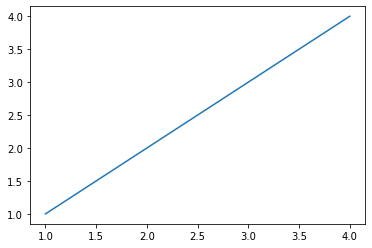

In [67]:
sns.lineplot(x = [1,2,3,4], y = [1,2,3,4])